# Art classification using deep learning

My goal for this project is to classify two artistic styles, western (Rococo), and Japanese using neural networks. In this notebook, I've used NN and CNN to achieve this task.


## CNN Implementation

### 1. Reading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import matplotlib.image as mpimg
import keras_cv

2023-12-19 18:40:47.471164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
# importing the date prepared in data_prep.ipynb
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='train_test/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    seed=1992,
    shuffle=False)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='train_test/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(256, 256),
    seed=1992,
    shuffle=False)

Found 3748 files belonging to 2 classes.
Found 938 files belonging to 2 classes.


2023-12-19 18:40:50.205801: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### 2. Model implementation

In [3]:
xy = 256

In [4]:
# preparing a data augmentation sequence to add more samples to the dataset
data_augmentation = tf.keras.Sequential([
    # scale and rotation
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2), 
    # color
    tf.keras.layers.RandomContrast(factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2),
    keras_cv.layers.RandomSaturation(factor=0.2),
    keras_cv.layers.RandomHue(factor=0.2, value_range=(0,255)),
    keras_cv.layers.RandomSharpness(factor=0.2, value_range=(0,255)),
    keras_cv.layers.ChannelShuffle(),
    keras_cv.layers.RandomColorDegeneration(factor=0.2),
    # # noise
    tf.keras.layers.GaussianNoise(0.1),
    keras_cv.layers.RandomShear(x_factor=0.3,y_factor=0.3,),

])

In [5]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(xy, xy, 3)),

    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [37]:
# stops the training if the model stops improving for 5 epochs
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 3, 
    restore_best_weights = True, 
    verbose = 1,
    monitor='val_loss')


# setting up learning rate for faster convergance
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# setting the opitmizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_cnn.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'] 
)

# fitting the model
history_cnn = model_cnn.fit(train_ds, 
                                 epochs=5,
                                 validation_data=test_ds,
                                 callbacks = [early_stopping_callbacks])

Epoch 1/5
118/118 [==============================] - 224s 2s/step - loss: 1.3980 - accuracy: 0.6964 - val_loss: 2.2762 - val_accuracy: 0.5288
Epoch 2/5
118/118 [==============================] - 227s 2s/step - loss: 0.9790 - accuracy: 0.5000 - val_loss: 0.7017 - val_accuracy: 0.5288
Epoch 3/5
118/118 [==============================] - 226s 2s/step - loss: 0.7027 - accuracy: 0.5291 - val_loss: 0.6957 - val_accuracy: 0.5288
Epoch 4/5
118/118 [==============================] - 226s 2s/step - loss: 0.7014 - accuracy: 0.5291 - val_loss: 0.6948 - val_accuracy: 0.5288
Epoch 5/5
118/118 [==============================] - 226s 2s/step - loss: 0.6971 - accuracy: 0.5392 - val_loss: 1.0620 - val_accuracy: 0.5288


In [7]:
# saving the model
import pickle

# Pickle the model
with open("model_cnn.pkl", "wb") as file:
    pickle.dump(model_cnn, file)

### 3. Evaluation

In [16]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc_cnn)

30/30 - 12s - loss: 0.6929 - accuracy: 0.5288 - 12s/epoch - 388ms/step

Test accuracy: 0.5287846326828003


In [17]:
probability_model = tf.keras.Sequential([
    model_cnn, 
    tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)

30/30 [==============================] - 12s 379ms/step


#### varify prediction

In [18]:
predictions[0]

array([0.47026366, 0.5297364 ], dtype=float32)

In [19]:
test_ds.class_names

['Japanese_Art', 'Rococo']

2023-12-20 09:46:13.294692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [938]
	 [[{{node Placeholder/_4}}]]
2023-12-20 09:46:13.295149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [938]
	 [[{{node Placeholder/_4}}]]


(256, 256, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


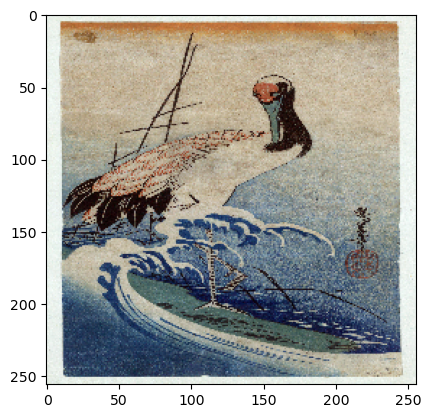

In [20]:
# print the first image in the testset
for images, labels in test_ds.take(1):
    first_image = images[0]
    first_label = labels[0]

print(first_image.shape)
print(first_label)
plt.imshow(first_image.numpy().astype(int))

In [21]:
# now let's see the prediction
img_array = np.expand_dims(first_image, axis=0)
probability_model.predict(img_array)

1/1 [==============================] - 0s 52ms/step


array([[0.47026366, 0.5297364 ]], dtype=float32)

In [22]:
test_ds.class_names

['Japanese_Art', 'Rococo']

#### confusion matrix

In [ ]:
# from sklearn.metrics import confusion_matrix

# y_prediction = model.predict(x_test)
# result = confusion_matrix(y_test, y_prediction , normalize='pred')

#### Accuracy and loss graphs

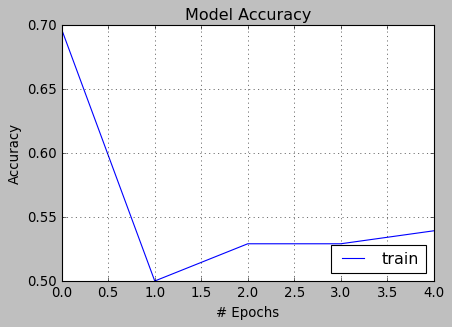

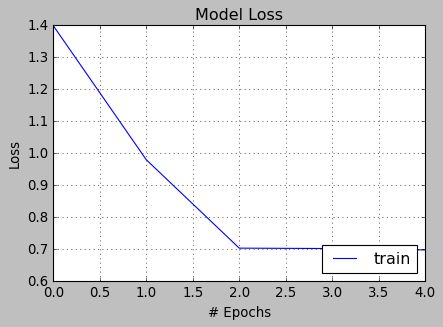

In [38]:
epoch = len(history_cnn.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),history_cnn.history.get('accuracy'))
#plt.plot(range(epoch),training_history.history.get('val_acc'))
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),history_cnn.history.get('loss'))
#plt.plot(range(epoch),training_history.history.get('val_loss'))
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'], loc=4)
plt.style.use(['classic'])

### 4. Summary

I employed Keras to read the data in batches, utilizing a batching approach for file ingestion. To augment the dataset and enhance the sample size input into the model, I implemented data augmentation techniques. My efforts involved a strategic combination of various convolutional, normalization, and regularization layers, resulting in the highest observed accuracy.

Despite these optimizations, the model's performance did not meet expectations. In light of this, I am inclined to further experiment with pretrained models and explore alternative network architectures, aiming to refine the model and achieve improved results. Additionally, I adjusted the learning rate for faster convergence and employed categorical cross-entropy as the evaluation metric for hot encoding loss.

# NN Implementation

In [ ]:
# defining the layers
model_nn = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2) 
])

In [35]:
# stops the training if the model stops improving for 5 epochs
early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
    patience = 3, 
    restore_best_weights = True, 
    verbose = 1,
    monitor='val_loss')


# setting up learning rate for faster convergance
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# setting the opitmizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model_nn.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] 
)

# fitting the model
history_nn = model_nn.fit(train_ds, 
                                 epochs=5,
                                 validation_data=test_ds,
                                 callbacks = [early_stopping_callbacks])

Epoch 1/5
118/118 [==============================] - 57s 476ms/step - loss: 0.7852 - accuracy: 0.4632 - val_loss: 0.8973 - val_accuracy: 0.5288
Epoch 2/5
118/118 [==============================] - 56s 474ms/step - loss: 0.7343 - accuracy: 0.4680 - val_loss: 0.6941 - val_accuracy: 0.5288
Epoch 3/5
118/118 [==============================] - 57s 479ms/step - loss: 0.6994 - accuracy: 0.5117 - val_loss: 0.6916 - val_accuracy: 0.5288
Epoch 4/5
118/118 [==============================] - 56s 475ms/step - loss: 0.6906 - accuracy: 0.5243 - val_loss: 0.8568 - val_accuracy: 0.5288
Epoch 5/5
118/118 [==============================] - 57s 481ms/step - loss: 0.7247 - accuracy: 0.4859 - val_loss: 0.7074 - val_accuracy: 0.5288


In [15]:
import pickle

# Pickle the model
with open("model_nn.pkl", "wb") as file:
    pickle.dump(model_nn, file)


In [24]:
test_loss_nn, test_acc_nn = model_nn.evaluate(test_ds, verbose=2)

print('\nTest accuracy:', test_acc_nn)

30/30 - 9s - loss: 0.6915 - accuracy: 0.5288 - 9s/epoch - 300ms/step

Test accuracy: 0.5287846326828003


In [26]:
probability_model = tf.keras.Sequential([
    model_nn, 
    tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_ds)

30/30 [==============================] - 9s 289ms/step


#### varify prediction

In [27]:
predictions[0]

array([0.4684566, 0.5315434], dtype=float32)

In [28]:
test_ds.class_names

['Japanese_Art', 'Rococo']

2023-12-20 09:58:37.080411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [938]
	 [[{{node Placeholder/_0}}]]
2023-12-20 09:58:37.080613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [938]
	 [[{{node Placeholder/_4}}]]


(256, 256, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)


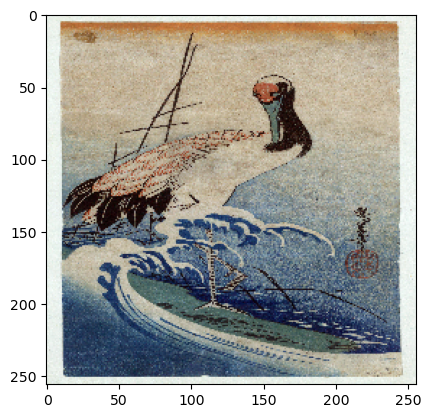

In [29]:
# print the first image in the testset
for images, labels in test_ds.take(1):
    first_image = images[0]
    first_label = labels[0]

print(first_image.shape)
print(first_label)
plt.imshow(first_image.numpy().astype(int))

In [30]:
# now let's see the prediction
img_array = np.expand_dims(first_image, axis=0)
probability_model.predict(img_array)

1/1 [==============================] - 0s 369ms/step


array([[0.4684566, 0.5315434]], dtype=float32)

In [31]:
test_ds.class_names

['Japanese_Art', 'Rococo']

The picture apperantelty a japanese art but the model believes it to be western art

#### accuracy and loss graph

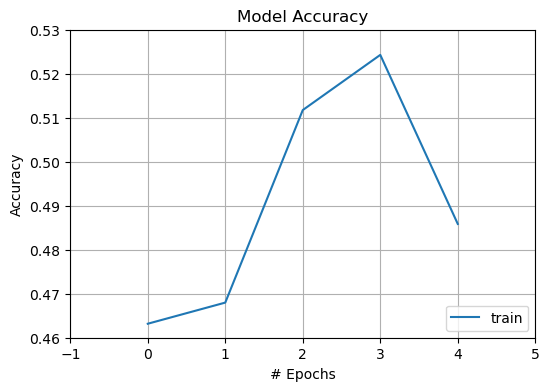

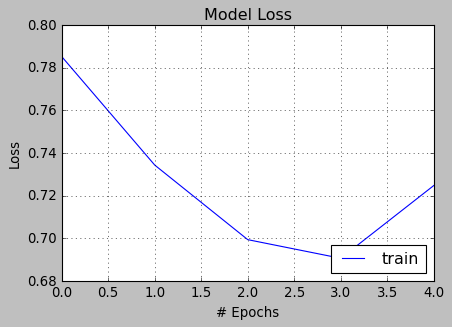

In [36]:
epoch = len(history_nn.history.get('loss',[]))

# Draw Model Accuracy
plt.figure(2,figsize=(6,4))
plt.plot(range(epoch),history_nn.history.get('accuracy'))
#plt.plot(range(epoch),training_history.history.get('val_acc'))
plt.xlabel('# Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(True)
plt.legend(['train','validation'],loc=4)
plt.style.use(['classic'])

# Draw Model Loss
plt.figure(1,figsize=(6,4))
plt.plot(range(epoch),history_nn.history.get('loss'))
#plt.plot(range(epoch),training_history.history.get('val_loss'))
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(True)
plt.legend(['train','validation'], loc=4)
plt.style.use(['classic'])

### 4. Summary

The outcomes from the neural network (NN) fell short of expectations and did not meet the desired level of performance. I am confident that the accuracy of the model can be significantly enhanced by leveraging pretrained models and exploring diverse network architectures.

# Conculusion

The outcomes of this project fell short of expectations, underscoring the limitations of conventional methods in tackling the identified issue. My exploration extended to experimenting with various architectures, integrating transfer learning through pretrained models, enhancing infrastructure complexity, and adjusting epoch numbers. Unfortunately, none of these interventions yielded the desired accuracy, except for a marginal improvement observed when increasing the number of epochs.

**Key Challenges**

1- Data Processing Challenge: A significant obstacle was effectively processing data without system crashes. This prompted my exploration of data reading approaches using Keras.

2- Limited Sample Size: The relatively small sample size emerged as another hurdle, with the belief that expanding it could potentially enhance overall accuracy.

3- Style Similarity Challenge: Recognizing subtle differences in art styles presented a challenge. During the project, I pondered whether a larger sample size or more distinct art styles could contribute to improved accuracy.

**Future Endeavors**

Moving forward, I aim to incorporate a comprehensive range of art styles and conduct further experiments with pretrained models to elevate the system's accuracy. This iterative approach seeks to address the identified challenges and refine the model for more robust performance.